In [1]:
# run this cell to ensure course package is installed
import sys
from pathlib import Path

course_tools_path = Path('../Course_Tools/').resolve() # change this to the local path of the course package
sys.path.append(str(course_tools_path))

from install_introdl import ensure_introdl_installed
ensure_introdl_installed(force_update=False, local_path_pkg= course_tools_path / 'introdl')

The `introdl` module is already installed.


In [2]:
# imports and configuration

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import OneCycleLR

import torchvision.models as models
import torchvision.transforms.v2 as T
from torchvision.models import resnet18, ResNet18_Weights

from torchinfo import summary

from introdl.utils import get_device, load_results, load_model, config_paths_keys
from introdl.idlmam import train_network
from introdl.visul import plot_training_metrics, plot_transformed_images, create_image_grid, evaluate_classifier

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [8, 6]  # Set the default figure size (width, height) in inches

paths = config_paths_keys()
MODELS_PATH = paths['MODELS_PATH']
DATA_PATH = paths['DATA_PATH']

MODELS_PATH=C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\models
DATA_PATH=C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\data
TORCH_HOME=C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\downloads
HF_HOME=C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\downloads


# Transfer Learning

In this notebook we'll illustrate transfer learning and fine-tuning on a small Kaggle dataset.  We'll use both the same ResNet18 model as in the textbook and a more advanced ConvNeXt model.  

## Cats, Dogs, and Foxes Dataset

#### L05_1_Preparing_the_Data Video

<iframe 
    src="https://media.uwex.edu/content/ds/ds776/ds776_l05_1_preparing_the_data/" 
    width="800" 
    height="450" 
    style="border: 5px solid cyan;"  
    allowfullscreen>
</iframe>
<br>
<a href="https://media.uwex.edu/content/ds/ds776/ds776_l05_1_preparing_the_data/" target="_blank">Open UWEX version of video in new tab</a>
<br>
<a href="https://share.descript.com/view/7LuYJO23g2x" target="_blank">Open Descript version of video in new tab</a>

---

This small, balanced [dataset on Kaggle](https://www.kaggle.com/datasets/snmahsa/animal-image-dataset-cats-dogs-and-foxes) contains 310 images of cats, dogs, and foxes.  That's far too few images to train a decent model from scratch, but by starting with a model that has been pretrained we can adapt it to classifying our data.  Most pre-trained image classification models have been trained on [Imagenet](https://www.image-net.org/) which has 1.28 million training images across 1,000 classes that cover a wide variety of objects, animals, and scenes.  Specifically, Imagenet includes images of cats, dogs, and foxes but not the same images as in the Kaggle dataset.

### Getting the dataset

Run the cell below to download the dataset from Kagglehub.  It will first download it to a temporary directory, but we'll move to a folder called 'cats_dogs_foxes' in your DATA_PATH directory. Along the way we do a couple of extra things:
1. rename a file that has an incorrect extension
2. delete two files that don't process correctly
3. resize the images so their shortest edge is at most 300 pixels to make experiments faster

You only need to run this cell once, but it won't hurt if you run it again.

Note:  resizing the images speeds up the Dataloaders below significantly because some of the original files were very large and had to opened and resized repeatedly for each training run.  When working with your own data you should consider preprocessing and saving the images before using them in your deep learning pipeline.

In [3]:
import kagglehub
import shutil
import os
from PIL import Image

# Define the destination path
destination_path = DATA_PATH / 'cats_dogs_foxes'

# Check if the destination path already exists
if destination_path.exists():
    print(f"Dataset already exists at: {destination_path}")
else:
    # Download latest version
    target_dataset = "snmahsa/animal-image-dataset-cats-dogs-and-foxes"
    path = kagglehub.dataset_download(target_dataset)
    print("Path to dataset files:", path)

    # Get the first folder in the downloaded path
    first_folder = next(os.scandir(path)).path

    # Rename and move the folder
    shutil.move(first_folder, destination_path)
    print(f"Dataset moved to: {destination_path}")

    # Split the path and remove everything at or deeper than 'snmahsa'
    path_parts = Path(path).parts
    snmahsa_index = path_parts.index('snmahsa')
    path_to_remove = Path(*path_parts[:snmahsa_index + 1])
    shutil.rmtree(path_to_remove)
    print(f"All files and folders in {path_to_remove} have been removed.")

    # Rename the file 'cat/cat006.jpg!d' to 'cat/cat006.jpg'
    file_to_rename = destination_path / 'cat/cat006.jpg!d'
    new_file_name = destination_path / 'cat/cat006.jpg'

    if file_to_rename.exists():
        file_to_rename.rename(new_file_name)
        print(f"Renamed {file_to_rename} to {new_file_name}")
    else:
        print(f"File {file_to_rename} does not exist.")

    # Delete the file 'cat/cat008.svg'
    file_to_delete = destination_path / 'cat/cat008.svg'
    if file_to_delete.exists():
        file_to_delete.unlink()
        print(f"Deleted {file_to_delete}")
    else:
        print(f"File {file_to_delete} does not exist.")

    # Delete the corrupted file 'fox/fox003.jpg'
    file_to_delete = destination_path / 'fox/fox003.jpg'
    if file_to_delete.exists():
        file_to_delete.unlink()
        print(f"Deleted {file_to_delete}")
    else:
        print(f"File {file_to_delete} does not exist.")

    # Resize images so the shortest edge is at most 300 pixels and save them as JPEGs
    for class_dir in destination_path.iterdir():
        if class_dir.is_dir():
            for img_path in class_dir.iterdir():
                if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                    try:
                        with Image.open(img_path) as img:
                            # Calculate the new size while maintaining the aspect ratio
                            ratio = 300 / min(img.size)
                            new_size = (int(img.size[0] * ratio), int(img.size[1] * ratio))
                            img = img.resize(new_size, Image.LANCZOS)
                            
                            # Save the image as JPEG
                            img.save(img_path, format='JPEG')
                            print(f"Resized and saved {img_path}")
                    except Exception as e:
                        print(f"Error processing {img_path}: {e}")
                else:
                    print(f"Skipping unsupported file type: {img_path}")


Dataset already exists at: C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\data\cats_dogs_foxes


### Inspecting the data

Let's look at a few of the images.  If you look at the dataset folder you'll see that the images are stored in directories for each class.  Like this:

```
DATA_PATH
└── cats_dogs_foxes
    ├── cat
    ├── dog
    └── fox
```

This is a common way to store image classification datasets and `torchvision.datasets.ImageFolder` makes it easy to create a PyTorch Dataset in this scenario.  Let's create the dataset and show some of the images.  By default, it will return PIL images, but our `create_image_grid` helper function can handle those.

In [4]:
full_dataset = ImageFolder( DATA_PATH / 'cats_dogs_foxes')
full_dataset

Dataset ImageFolder
    Number of datapoints: 308
    Root location: C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\data\cats_dogs_foxes

Run the cell below to create a 5x5 grid of randomly selected images from this dataset.

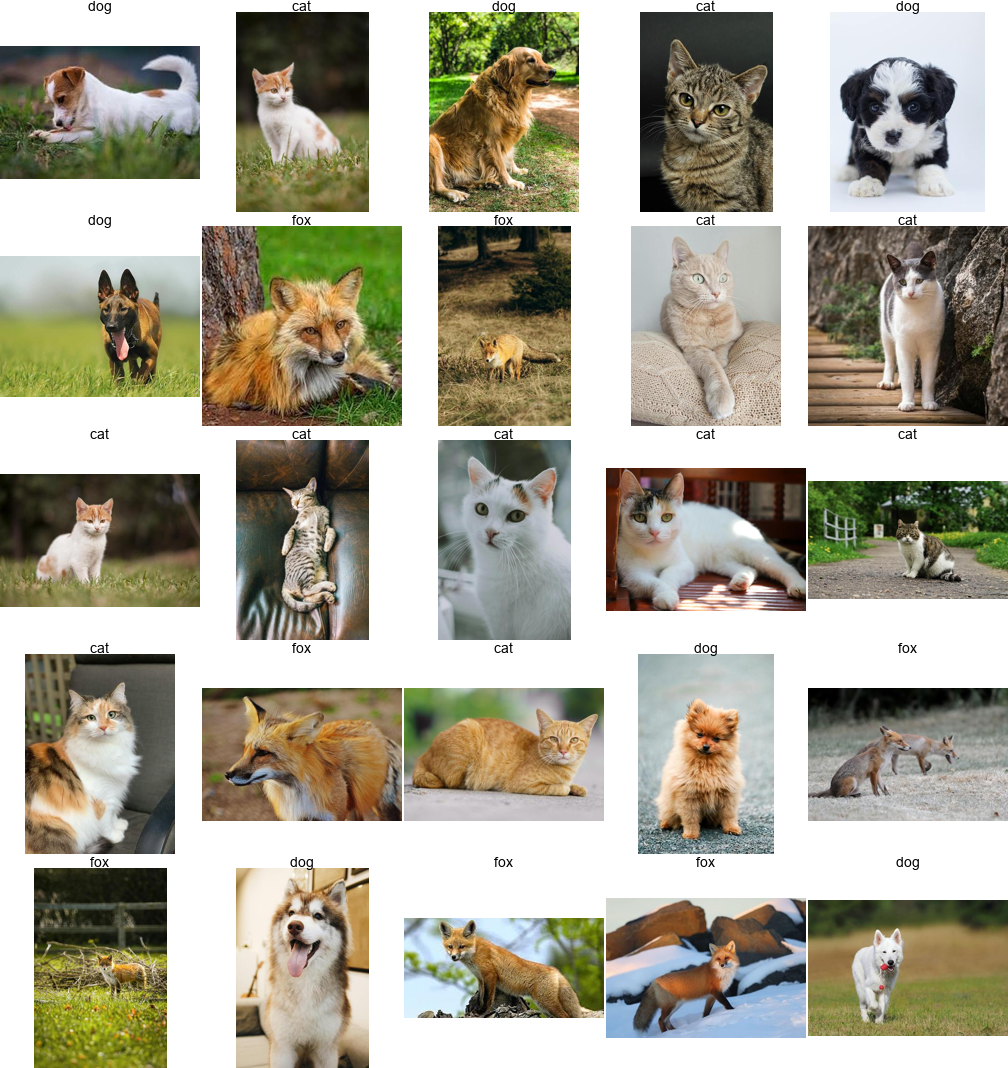

In [5]:
create_image_grid(full_dataset, nrows = 5, ncols = 5, img_size=(200,200), show_labels=True, pad=True)

# Data Augmentation

With such a small dataset we'll need to use agressive data augmentation to avoid overfitting.  Note that the animals tend to be centered in the photgraphs so to get the images to a uniform size of 224x224 we'll first resize the image so its shortest edge is 224 pixels, then crop the center of that image.  Later we apply a random crop with padding and a random rotation, both of which will introduce some black pixels on the borders of the transformed image.  An alternate way to hand handle the cropping and rotation would be to resize and center crop to a slightly larger size, like 256x256, then rotate and then do a random crop to 224x224.  

As you learn about data augmentation you may find it helpful to use ChatGPT or a similar AI to get suggestions.  For example, a prompt like this: "I have a tiny image dataset of foxes, cats, and dogs and want to fine-tune an image classification model.  Suggest separate training and validation transformation pipelines for data augmentation.  The images should be sized to 224x224 and normalized using Imagenet statistics.  Use torchvisions.transforms.v2" would give a starting point.

In [6]:
mean = [0.485, 0.456, 0.406]  # Example mean values, replace with yours if needed
std = [0.229, 0.224, 0.225]  # Example std values, replace with yours if needed

transform_train = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize(224, max_size=None),  # Resize so the shortest edge is 224
    T.CenterCrop(224),            # Center crop to 224x224
    T.RandomRotation(degrees=15),
    T.RandomCrop(224, padding=10),            # Random crop padded img to 224x224
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.RandomGrayscale(),
    T.Normalize(mean=mean, std=std),
    T.ToPureTensor()
])

transform_val = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize(224, max_size=None),  # Resize so the shortest edge is 256
    T.CenterCrop(224),            # Center crop to 256x256
    T.Normalize(mean=mean, std=std),
    T.ToPureTensor()
])



In [7]:
full_train_dataset = ImageFolder(DATA_PATH / 'cats_dogs_foxes',transform=transform_train)
full_val_dataset = ImageFolder(DATA_PATH / 'cats_dogs_foxes', transform=transform_val)
train_indices, val_indices = train_test_split(list(range(len(full_train_dataset))), train_size=0.8, random_state=42)

train_dataset = Subset(full_train_dataset, train_indices)
val_dataset = Subset(full_val_dataset, val_indices)

# for later visualization
train_dataset.classes = full_train_dataset.classes
val_dataset.classes = full_val_dataset.classes


Let's look at some of the images that have been transformed multiple times to get an idea of how the data augmentation is working.  If you execute the cell below again, you'll get a different set of images.

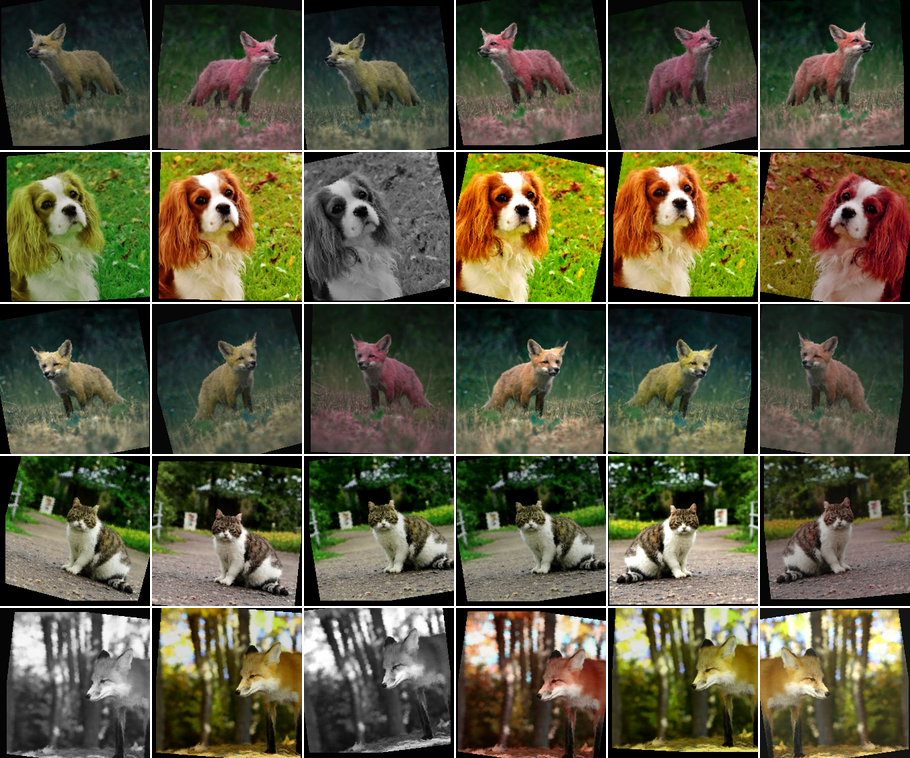

In [8]:
plot_transformed_images(train_dataset, img_size=(150,150), mean=mean, std=std)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

## Downloading and Preparing a Model for a New Task

#### L05_2_Preparing_the_Model Video

<iframe 
    src="https://media.uwex.edu/content/ds/ds776/ds776_l05_2_preparing_the_model/" 
    width="800" 
    height="450" 
    style="border: 5px solid cyan;"  
    allowfullscreen>
</iframe>
<br>
<a href="https://media.uwex.edu/content/ds/ds776/ds776_l05_2_preparing_the_model/" target="_blank">Open UWEX version of video in new tab</a>
<br>
<a href="https://share.descript.com/view/UjT7lrMjSxW" target="_blank">Open Descript version of video in new tab</a>

---

To adapt a model that has been pretrained on Imagenet to a new classification task we'll have to download the model and, at the very least, replace the final linear output layer with a new output layer that has the number of classes for its number of outputs.  We will probably also want to be able to identify freeze the base layers of the network (often called the "backbone") to prevent their weights from being updated in training.  

For our first example we'll use [ResNet18](https://paperswithcode.com/paper/deep-residual-learning-for-image-recognition) as the textbook did. It's a good, lightweight model that can establish a baseline for what you can do with transfer learning for your problem.  We'll download the model from torchvision.models.  You can find more information about the [torchvision.models API here](https://pytorch.org/vision/main/models.html).


In [10]:
# import torchvision.models as models
model = models.resnet18(weights="DEFAULT")
summary(model, 
        input_size=(32,3,224,224), 
        col_names=["input_size", "output_size", "num_params"], 
        row_settings=["var_names"],
        depth=1) 

Layer (type (var_name))                  Input Shape               Output Shape              Param #
ResNet (ResNet)                          [32, 3, 224, 224]         [32, 1000]                --
├─Conv2d (conv1)                         [32, 3, 224, 224]         [32, 64, 112, 112]        9,408
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]        [32, 64, 112, 112]        128
├─ReLU (relu)                            [32, 64, 112, 112]        [32, 64, 112, 112]        --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]        [32, 64, 56, 56]          --
├─Sequential (layer1)                    [32, 64, 56, 56]          [32, 64, 56, 56]          147,968
├─Sequential (layer2)                    [32, 64, 56, 56]          [32, 128, 28, 28]         525,568
├─Sequential (layer3)                    [32, 128, 28, 28]         [32, 256, 14, 14]         2,099,712
├─Sequential (layer4)                    [32, 256, 14, 14]         [32, 512, 7, 7]           8,393,728
├─Adapt

In [11]:
model.fc.in_features

512

The layer we need to modify is that last Linear (fully-connected) layer in the last block.  

In [12]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

We need to replace it with a Linear layer with 1024 inputs and 3 outputs for our 3 classes.  We'll read the number of inputs from the existing layer and change the last layer like this:

In [13]:
model.fc = nn.Linear(model.fc.in_features, 3)

We also want to freeze all of the base layers (those in the *features* block) which means we need to set the requires_grad attribute of all the parameter tensors to False in the base layers.  We could also freeze the first linear layer in the *classifier* block.  We experimented with both ways and it didn't seem to make much difference.  Here's the code we'll use to freeze all the layers in the "backbone" and not the layers in the "head":  

We also want to freeze all of the layers in the "backbone" except for the linear output layer.  This requires us to set the `requires_grad` attribue to all the parameter tensors to `False` except the classification "head" which in this case is the single output layer `model.fc`.  We'll do this by freezing all the layers in the model, then unfreezing model.fc.

In [14]:
# freeze all but the head
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

When using transfer learning I find it helpful to build a custom model class to load the model, change the output layer to have the correct number of output, and to freeze and unfreeze the backbone.  ChatGPT or another AI can help you write it for all of the well established pre-trained models in torchvision.models.  Here is the prompt I used.  

"Write a PyTorch nn.Module class ResNet18Custom that modifies the final layer of resnet18 for a specified num_outputs.  Pass in weights, defaults to none, to load pretrained model weights.  Include methods to freeze all layers except the head (freeze_backbone) and to unfreeze all layers (unfreeze_backbone). Add docstrings for the class and its methods."

After using the prompt, I tweaked a couple of things, but it made a great starting point.  Here is the code:

In [15]:
class ResNet18Custom(nn.Module):
    """
    A custom ResNet18 model with a modified final layer for a specified number of output classes.

    Args:
        num_outputs (int): The number of output classes for the modified final layer.
        weights (ResNet18_Weights or None): Pretrained weights to load for ResNet18. If None, the model is randomly initialized.

    Methods:
        freeze_backbone(): Freezes all layers of the backbone except the final classification head.
        unfreeze_backbone(): Unfreezes all layers of the backbone.
    """
    def __init__(self, num_outputs: int, weights=None):
        """
        Initializes the ResNet18Custom model.

        Args:
            num_outputs (int): The number of output classes for the modified final layer.
            weights (ResNet18_Weights or None): Pretrained weights for ResNet18. Defaults to None.
        """
        super(ResNet18Custom, self).__init__()
        # Load ResNet18 with specified weights (pretrained or None)
        self.model = models.resnet18(weights=weights)
        
        # Replace the final fully connected layer to fit the desired output size
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_outputs)

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, num_outputs).
        """
        return self.model(x)

    def freeze_backbone(self):
        """
        Freezes all layers of the backbone except the final classification head.
        This is useful for transfer learning scenarios where only the head is fine-tuned.
        """
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Ensure the final fully connected layer remains trainable
        for param in self.model.fc.parameters():
            param.requires_grad = True

    def unfreeze_backbone(self):
        """
        Unfreezes all layers of the backbone, allowing the entire model to be fine-tuned.
        """
        for param in self.model.parameters():
            param.requires_grad = True


## Training from Scratch

The dataset has only 307 images before splitting into training and validation sets so training any sort of CNN from scratch is unlikely to work well.  Let's try it anyway just to see what happens.  

Here we'll load the model without any pretrained model weights and train it for 40 epochs using our usual workflow.  Below we train for 40 epochs for illustration, but if you're running this code you can reduce that to see how it works.

In [16]:
model = ResNet18Custom(num_outputs=3)
loss_func = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.AdamW(model.parameters())  # Adam optimizer

device = get_device()
print(device)

ckpt_file = MODELS_PATH / 'L05_animals_resnet18_from_scratch.pt'
epochs = 40

score_funcs = {'ACC':accuracy_score}
results = train_network(model,
                        loss_func,
                        train_loader,
                        device=device,
                        val_loader=val_loader,
                        epochs = epochs,
                        optimizer = optimizer,
                        score_funcs = score_funcs,
                        checkpoint_file=ckpt_file,
                        pretend_train=True)

cuda


Pretend Training:   0%|          | 0/40 [00:00<?, ?it/s]

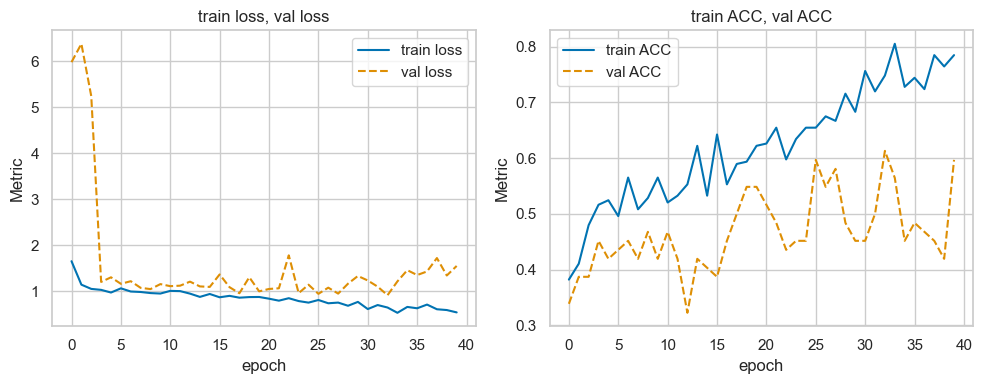

In [17]:
ckpt_file = MODELS_PATH / 'L05_animals_resnet18_from_scratch.pt'
AdamW_augment = load_results(ckpt_file)

plot_training_metrics(AdamW_augment, [['train loss', 'val loss'], ['train ACC', 'val ACC']])

Training for 40 epochs was overkill, but we did it to illustrate the overfitting which is pretty clearly occuring in the first few epochs.  Notice that the model accuracy is about 50% on the validation set which is little better than guessing since there are only three classes in this data.  The model is slowly memorizing the training data and mostly failing to generalize to the validation data.  Training from scratch simply isn't going to work here.

## Transfer Learning

#### L05_2_Transfer_Learning Video

<iframe 
    src="https://media.uwex.edu/content/ds/ds776/ds776_l05_2_transfer_learning/" 
    width="800" 
    height="450" 
    style="border: 5px solid cyan;"  
    allowfullscreen>
</iframe>
<br>
<a href="https://media.uwex.edu/content/ds/ds776/ds776_l05_2_transfer_learning/" target="_blank">Open UWEX version of video in new tab</a>
<br>
<a href="https://share.descript.com/view/7LuYJO23g2x" target="_blank">Open Descript version of video in new tab</a>

---

*Transfer learning* is the process of *adapting a pretrained model to a new but related task*, instead of training from scratch. This is useful when:

* The new dataset is too small to train a large model from scratch.
* The pretrained model has learned general features that can be useful for the new task.
* Training from scratch would be computationally expensive.

There are **three main types** of transfer learning:

| **Type of Transfer Learning**  | **Description**  | **Fine-Tuning Required?**  | **Base Layers Trainable?** |
|-------------------------------|-----------------|------------------|--------------------|
| **Feature Extraction**  | Use a pretrained model as a **fixed feature extractor**. Freeze all base layers and replace the classification head. | **No (only training the new head)** | **Base layers frozen** |
| **Fine-Tuning (Partial)** | Use a pretrained model, freeze most layers, but train a few deeper layers along with the new head. | **Yes** | **Some base layers trainable** |
| **Full Fine-Tuning** | Unfreeze the entire pretrained model and fine-tune all layers. | **Yes** | **All base layers trainable** |

The process described in the book is to start with feature extraction for a few epochs and then to continue will full fine-tuning for a few more epochs.  Too much full fine-tuning can easily lead to overfitting, so we'll be conservative and only use a few epochs.  You should note that there are many variations on this process, but they all start with a pretrained model and try to leverage the knowledge in that model to a new task.

To do transfer learning here, we'll load the pretrained version of the model from torchvision.  The code to do that is in our custom model class, but it would normally look like this:

```python
model = models.resnet18(weights="DEFAULT")
```

Most common models in torchvision are pretrained on Imagenet and those weights can usually be loaded by specifying `weights="DEFAULT"`, but there are sometimes other choices of weights.  To learn more about pretrained models and their weights you can read the [Models and pre-trained weights](https://pytorch.org/vision/stable/models.html?utm_source=chatgpt.com) section of the PyTorch documentation.  

Here is a summary of how we'll do feature extraction using ResNet18 for our dataset:
1.  Instantiate our custom model with 3 classes and "DEFAULT" Imagenet weights
2.  Freeze everything but the output layer.
3.  Train that layer for 8 epochs with early stopping.

Early stopping ensures that model with the best validation performance is saved and also helps to reduce overfitting by stopping when validation performance stops improving.

In [18]:
model = ResNet18Custom(num_outputs=3, weights = "DEFAULT")
model.freeze_backbone()

loss_func = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.AdamW(model.parameters())  # Adam optimizer

device = get_device()
print(device)

ckpt_file = MODELS_PATH / 'L05_animals_resnet18_transfer_frozen_backbone.pt'
epochs = 8

score_funcs = {'ACC':accuracy_score}
results = train_network(model,
                        loss_func,
                        train_loader,
                        device=device,
                        val_loader=val_loader,
                        epochs = epochs,
                        optimizer = optimizer,
                        score_funcs = score_funcs,
                        checkpoint_file=ckpt_file,
                        early_stop_crit='max',
                        early_stop_metric='ACC',
                        patience=3,
                        pretend_train=True)

cuda


Pretend Training:   0%|          | 0/8 [00:00<?, ?it/s]

In [19]:
ckpt_file = MODELS_PATH / 'L05_animals_resnet18_transfer_frozen_backbone.pt'
results = load_results(ckpt_file)
results

,epoch,total time,train loss,val loss,train ACC,val ACC
0,0,2.837531,1.185347,0.955956,0.345528,0.483871
1,1,5.698352,0.782314,0.672232,0.703252,0.806452
2,2,8.607752,0.573351,0.562212,0.853659,0.806452
3,3,11.392990,0.416484,0.421253,0.934959,0.870968
4,4,14.184384,0.370142,0.372706,0.922764,0.870968
5,5,17.186067,0.285433,0.348815,0.951220,0.887097
6,6,20.215514,0.273002,0.283186,0.947154,0.935484


Wow!  Over 93% validation accuracy with almost no effort.  Notice that the training and validation losses are quite similar throughout the training which suggests we're not overfitting.  

After training the output layer we can try to *fine-tune* the whole model.  It may not work well here since we have so little training data, but we'll try it.  Here's what to do:
1. Load the model with the results of training with the frozen backbone.
2. Unfreeze the backbone.
3. Train it for a few epochs.  It's common to use a scheduler like OneCycleLR to accelerate convergence, but also to use a small learning rate because we don't want to change the base layers much.  If the base layers change too much we risk losing some of the pretrained model's ability to extract good features based on its pretraining.

Again, we use early stopping to ensure that our best version of the model is saved.

In [ ]:
# load the model with the frozen backbone and unfreeze it
model = load_model(ResNet18Custom(num_outputs=3), MODELS_PATH / 'L05_animals_resnet18_transfer_frozen_backbone.pt')
model.unfreeze_backbone()

# Configure Training for unfrozen model
ckpt_file = MODELS_PATH / 'L05_animals_resnet18_transfer_unfrozen_backbone.pt'
epochs = 3
optimizer = optim.AdamW(model.parameters())
scheduler = OneCycleLR(optimizer, max_lr=0.0001, epochs=epochs, steps_per_epoch=len(train_loader))

# Train and save
results = train_network(model,
                        loss_func,
                        train_loader,
                        device=device,
                        val_loader=val_loader,
                        epochs = epochs,
                        optimizer = optimizer,
                        score_funcs = score_funcs,
                        checkpoint_file=ckpt_file,
                        lr_schedule=scheduler,
                        scheduler_step_per_batch=True,
                        early_stop_crit='max',
                        early_stop_metric='ACC',
                        patience=1,
                        pretend_train=True)

Pretend Training:   0%|          | 0/3 [00:00<?, ?it/s]

In [21]:
ckpt_file = MODELS_PATH / 'L05_animals_resnet18_transfer_unfrozen_backbone.pt'
results = load_results(ckpt_file)
results

,epoch,total time,train loss,val loss,train ACC,val ACC,lr
0,0,2.952316,0.179870,0.160252,0.971545,0.935484,9.719418e-05
1,1,5.915602,0.076462,0.104267,0.987805,0.967742,3.705930e-05
2,2,8.785928,0.053756,0.097746,0.995935,0.967742,8.720729e-07


If you run the last few cells over you'll likely get different results.  It can happen that you get the best results early from freezing the backbone or that the best results come from the finetuning we do with the unfrozen backbone.

Assuming that the unfrozen backbone training gave the best result.  Let's load and evaluate that model:

The dataset has 62 samples.
The model misclassified 2 samples.


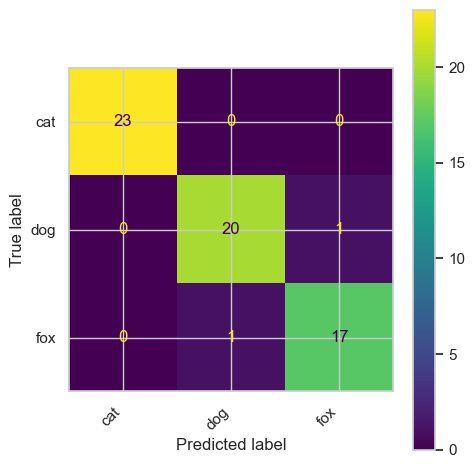

In [22]:
model = load_model(ResNet18Custom(num_outputs=3), MODELS_PATH / 'L05_animals_resnet18_transfer_unfrozen_backbone.pt')
device = get_device()
conf_mat,report,misses_dataset=evaluate_classifier(model, val_dataset, device)


In [23]:
# show the classification report
print(report)

              precision    recall  f1-score   support

         cat       1.00      1.00      1.00        23
         dog       0.95      0.95      0.95        21
         fox       0.94      0.94      0.94        18

    accuracy                           0.97        62
   macro avg       0.97      0.97      0.97        62
weighted avg       0.97      0.97      0.97        62



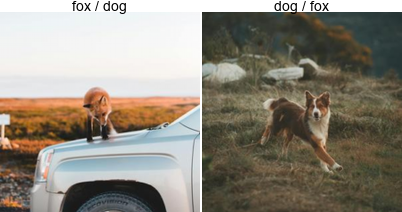

In [24]:
create_image_grid(misses_dataset, nrows=2, ncols=5, img_size=(200, 200), show_labels=True, mean=mean, std=std)

## Using other models

While the pretrained ResNet18 model did a pretty amazing job on our dataset, it's possible that a larger or more modern model could improve the performance. Since ResNet was introduced in 2015 image classification models have continued to advance.  

To get a summary of recent advancements try asking an AI to "briefly summarize, in chronological order, the most important and widely used advancements in image classification models since ResNet".   One of the models that should be mentioned in that list is ConvNeXt which is a state-of-the-art CNN model.

Here we'll illustrate how easy it to apply the smallest pre-trained ConvNeXt model to our dataset.  We'll start by building a custom class to load and modify the smallest ConvNeXt model and to provide methods for freezing and unfreezing the backbone.  One easy way to do this is to ask an AI to modify your the ResNet18Custom class from above to work with the smallest ConvNeXT model.

In [25]:
class ConvNeXtTinyCustom(nn.Module):
    """
    Custom ConvNeXt-Tiny model for a specified number of output classes.

    Attributes:
        model (torchvision.models.ConvNeXt): The ConvNeXt-Tiny model with a modified final layer.
        num_outputs (int): Number of output classes.
    """
    def __init__(self, num_outputs: int, weights=None):
        """
        Initializes the ConvNeXt-Tiny model and modifies the final layer.

        Args:
            num_outputs (int): The number of output classes for the modified ConvNeXt-Tiny model.
            weights: Pretrained weights to load into the model. Defaults to None.
        """
        super(ConvNeXtTinyCustom, self).__init__()
        self.num_outputs = num_outputs
        # Load ConvNeXt-Tiny model with specified weights
        self.model = models.convnext_tiny(weights=weights)
        # Replace the final classification head
        in_features = self.model.classifier[2].in_features
        self.model.classifier[2] = nn.Linear(in_features, num_outputs)

    def freeze_backbone(self):
        """
        Freezes all layers of the backbone except the final classification head.

        This method sets `requires_grad` to `False` for all layers except the final classification layer.
        """
        for param in self.model.parameters():
            param.requires_grad = False
        # Unfreeze the final fully connected layer
        for param in self.model.classifier[2].parameters():
            param.requires_grad = True

    def unfreeze_backbone(self):
        """
        Unfreezes all layers of the ConvNeXt-Tiny backbone.

        This method sets `requires_grad` to `True` for all layers.
        """
        for param in self.model.parameters():
            param.requires_grad = True

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).
        
        Returns:
            torch.Tensor: Output tensor of shape (batch_size, num_outputs).
        """
        return self.model(x)


Now we'll follow the same steps we used to for transfer learning with ResNet18.

In [26]:
model = ConvNeXtTinyCustom(num_outputs=3, weights = "DEFAULT")
model.freeze_backbone()

loss_func = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.AdamW(model.parameters())  # Adam optimizer

device = get_device()
print(device)

ckpt_file = MODELS_PATH / 'L05_animals_convnexttiny.pt'
epochs = 8

score_funcs = {'ACC':accuracy_score}
results = train_network(model,
                        loss_func,
                        train_loader,
                        device=device,
                        val_loader=val_loader,
                        epochs = epochs,
                        optimizer = optimizer,
                        score_funcs = score_funcs,
                        checkpoint_file=ckpt_file,
                        early_stop_crit='max',
                        early_stop_metric='ACC',
                        patience=2,
                        pretend_train=True)

cuda


Pretend Training:   0%|          | 0/8 [00:00<?, ?it/s]

In [27]:
ckpt_file = MODELS_PATH / 'L05_animals_convnexttiny.pt'
results = load_results(ckpt_file)
results

,epoch,total time,train loss,val loss,train ACC,val ACC
0,0,3.052534,0.769881,0.543621,0.849593,0.935484
1,1,5.921638,0.394595,0.317853,0.979675,0.967742
2,2,8.790700,0.225042,0.219017,1.000000,0.983871
3,3,11.601023,0.153618,0.169229,0.995935,0.983871
4,4,14.437995,0.112324,0.140297,1.000000,0.983871
5,5,17.249849,0.088227,0.123214,1.000000,0.983871
6,6,20.236283,0.070120,0.110894,1.000000,0.983871
7,7,23.239143,0.078368,0.101721,0.987805,0.983871


The dataset has 62 samples.
The model misclassified 1 samples.


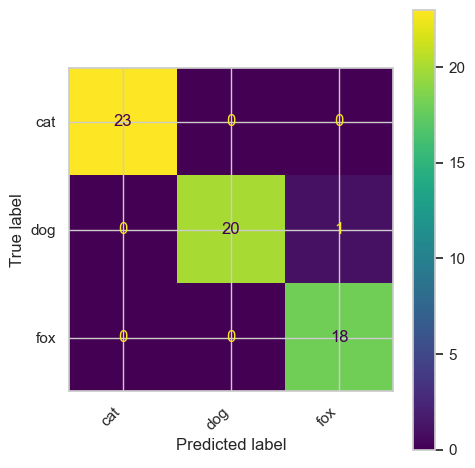

In [28]:
model = load_model(ConvNeXtTinyCustom(num_outputs=3), MODELS_PATH / 'L05_animals_convnexttiny.pt')
device = get_device()
conf_mat,report,missed_dataset=evaluate_classifier(model, val_dataset, device, img_size=(5,5))

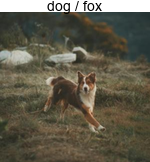

In [29]:
create_image_grid(missed_dataset, nrows=1, ncols=2, img_size=(150, 150), show_labels=True, mean=mean, std=std)

With just a little training the ConvNeXt model was able to correctly classify all but one dog.  That's pretty amazing.

This dataset is pretty easy since it contains images that are very similar those in the ImageNet training set. In the homework we'll have you explore transfer learning using a larger dataset that is a bit further from ImageNet.